# K-Mean Clustering

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Step 1: Read each CSV file into a Pandas DataFrame and filter data for the first 2 hours
directory = 'harth2'
csv_files = os.listdir(directory)
time_series_data = []

# Define the fixed length for padding or interpolation
fixed_length = 120  # Assuming 2 hours with 1 data point per minute

for csv_file in csv_files:
    if csv_file.endswith('.csv'):
        df = pd.read_csv(os.path.join(directory, csv_file))
        # Assuming the time column is named 'time'
        df['time_only'] = pd.to_datetime(df['time_only'])
        # Filter data within the first 2 hours
        df = df[(df['time_only'] >= '00:00:00.000000') & (df['time_only'] <= '02:00:00.000000')]
        # Extract the label column data as the time series data
        time_series = df['label'].values
        # Pad or interpolate the time series data to the fixed length
        if len(time_series) < fixed_length:
            # Pad with zeros if the data is shorter than fixed length
            padded_time_series = np.pad(time_series, (0, fixed_length - len(time_series)), 'constant')
            time_series_data.append(padded_time_series)
        elif len(time_series) > fixed_length:
            # Interpolate if the data is longer than fixed length
            interpolated_time_series = np.interp(np.linspace(0, len(time_series) - 1, fixed_length),
                                                 np.arange(len(time_series)), time_series)
            time_series_data.append(interpolated_time_series)
        else:
            time_series_data.append(time_series)

C:\Users\karag\AppData\Local\Temp\ipykernel_18908\1379914628.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_only'] = pd.to_datetime(df['time_only'])
C:\Users\karag\AppData\Local\Temp\ipykernel_18908\1379914628.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_only'] = pd.to_datetime(df['time_only'])
C:\Users\karag\AppData\Local\Temp\ipykernel_18908\1379914628.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['time_only'] = pd.to_datetime(df['time_only'])
C:\Users\karag\AppData\Local\Temp\ipykernel_18908\1379914628.py:20: UserWarning: Could n

In [2]:
len(time_series_data)

22

In [5]:
plt.rcParams['figure.figsize'] = [25, 8]
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import pandas as pd


seed = 0
np.random.seed(seed)
df = TimeSeriesScalerMeanVariance().fit_transform(df)
sz = df.shape[1]

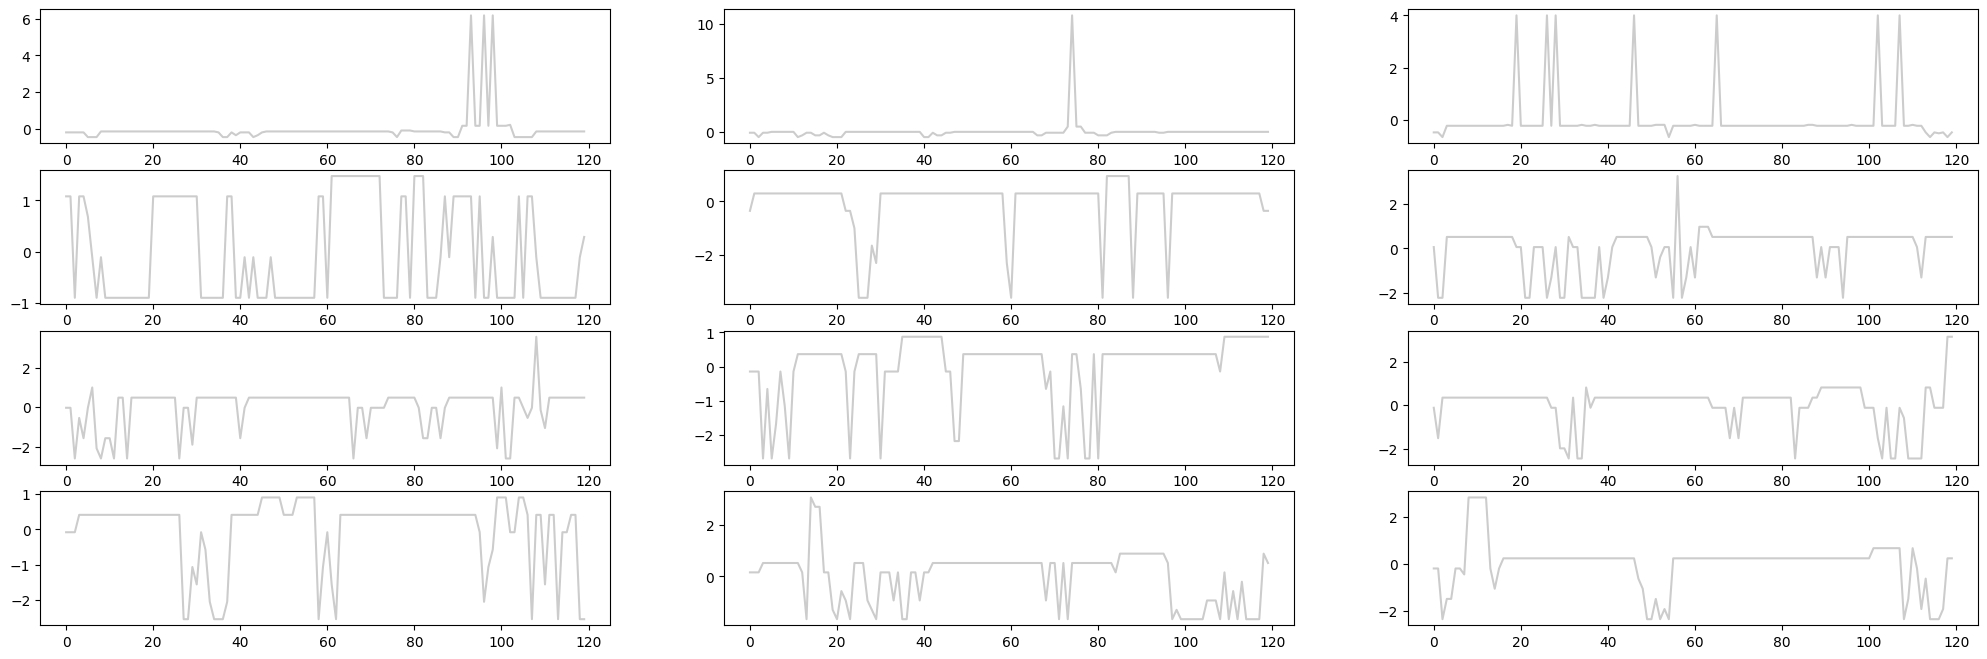

In [6]:
for yi in range(12):
    plt.subplot(4, 3, yi + 1)
    plt.plot(df[yi].ravel(), "k-", alpha=.2)

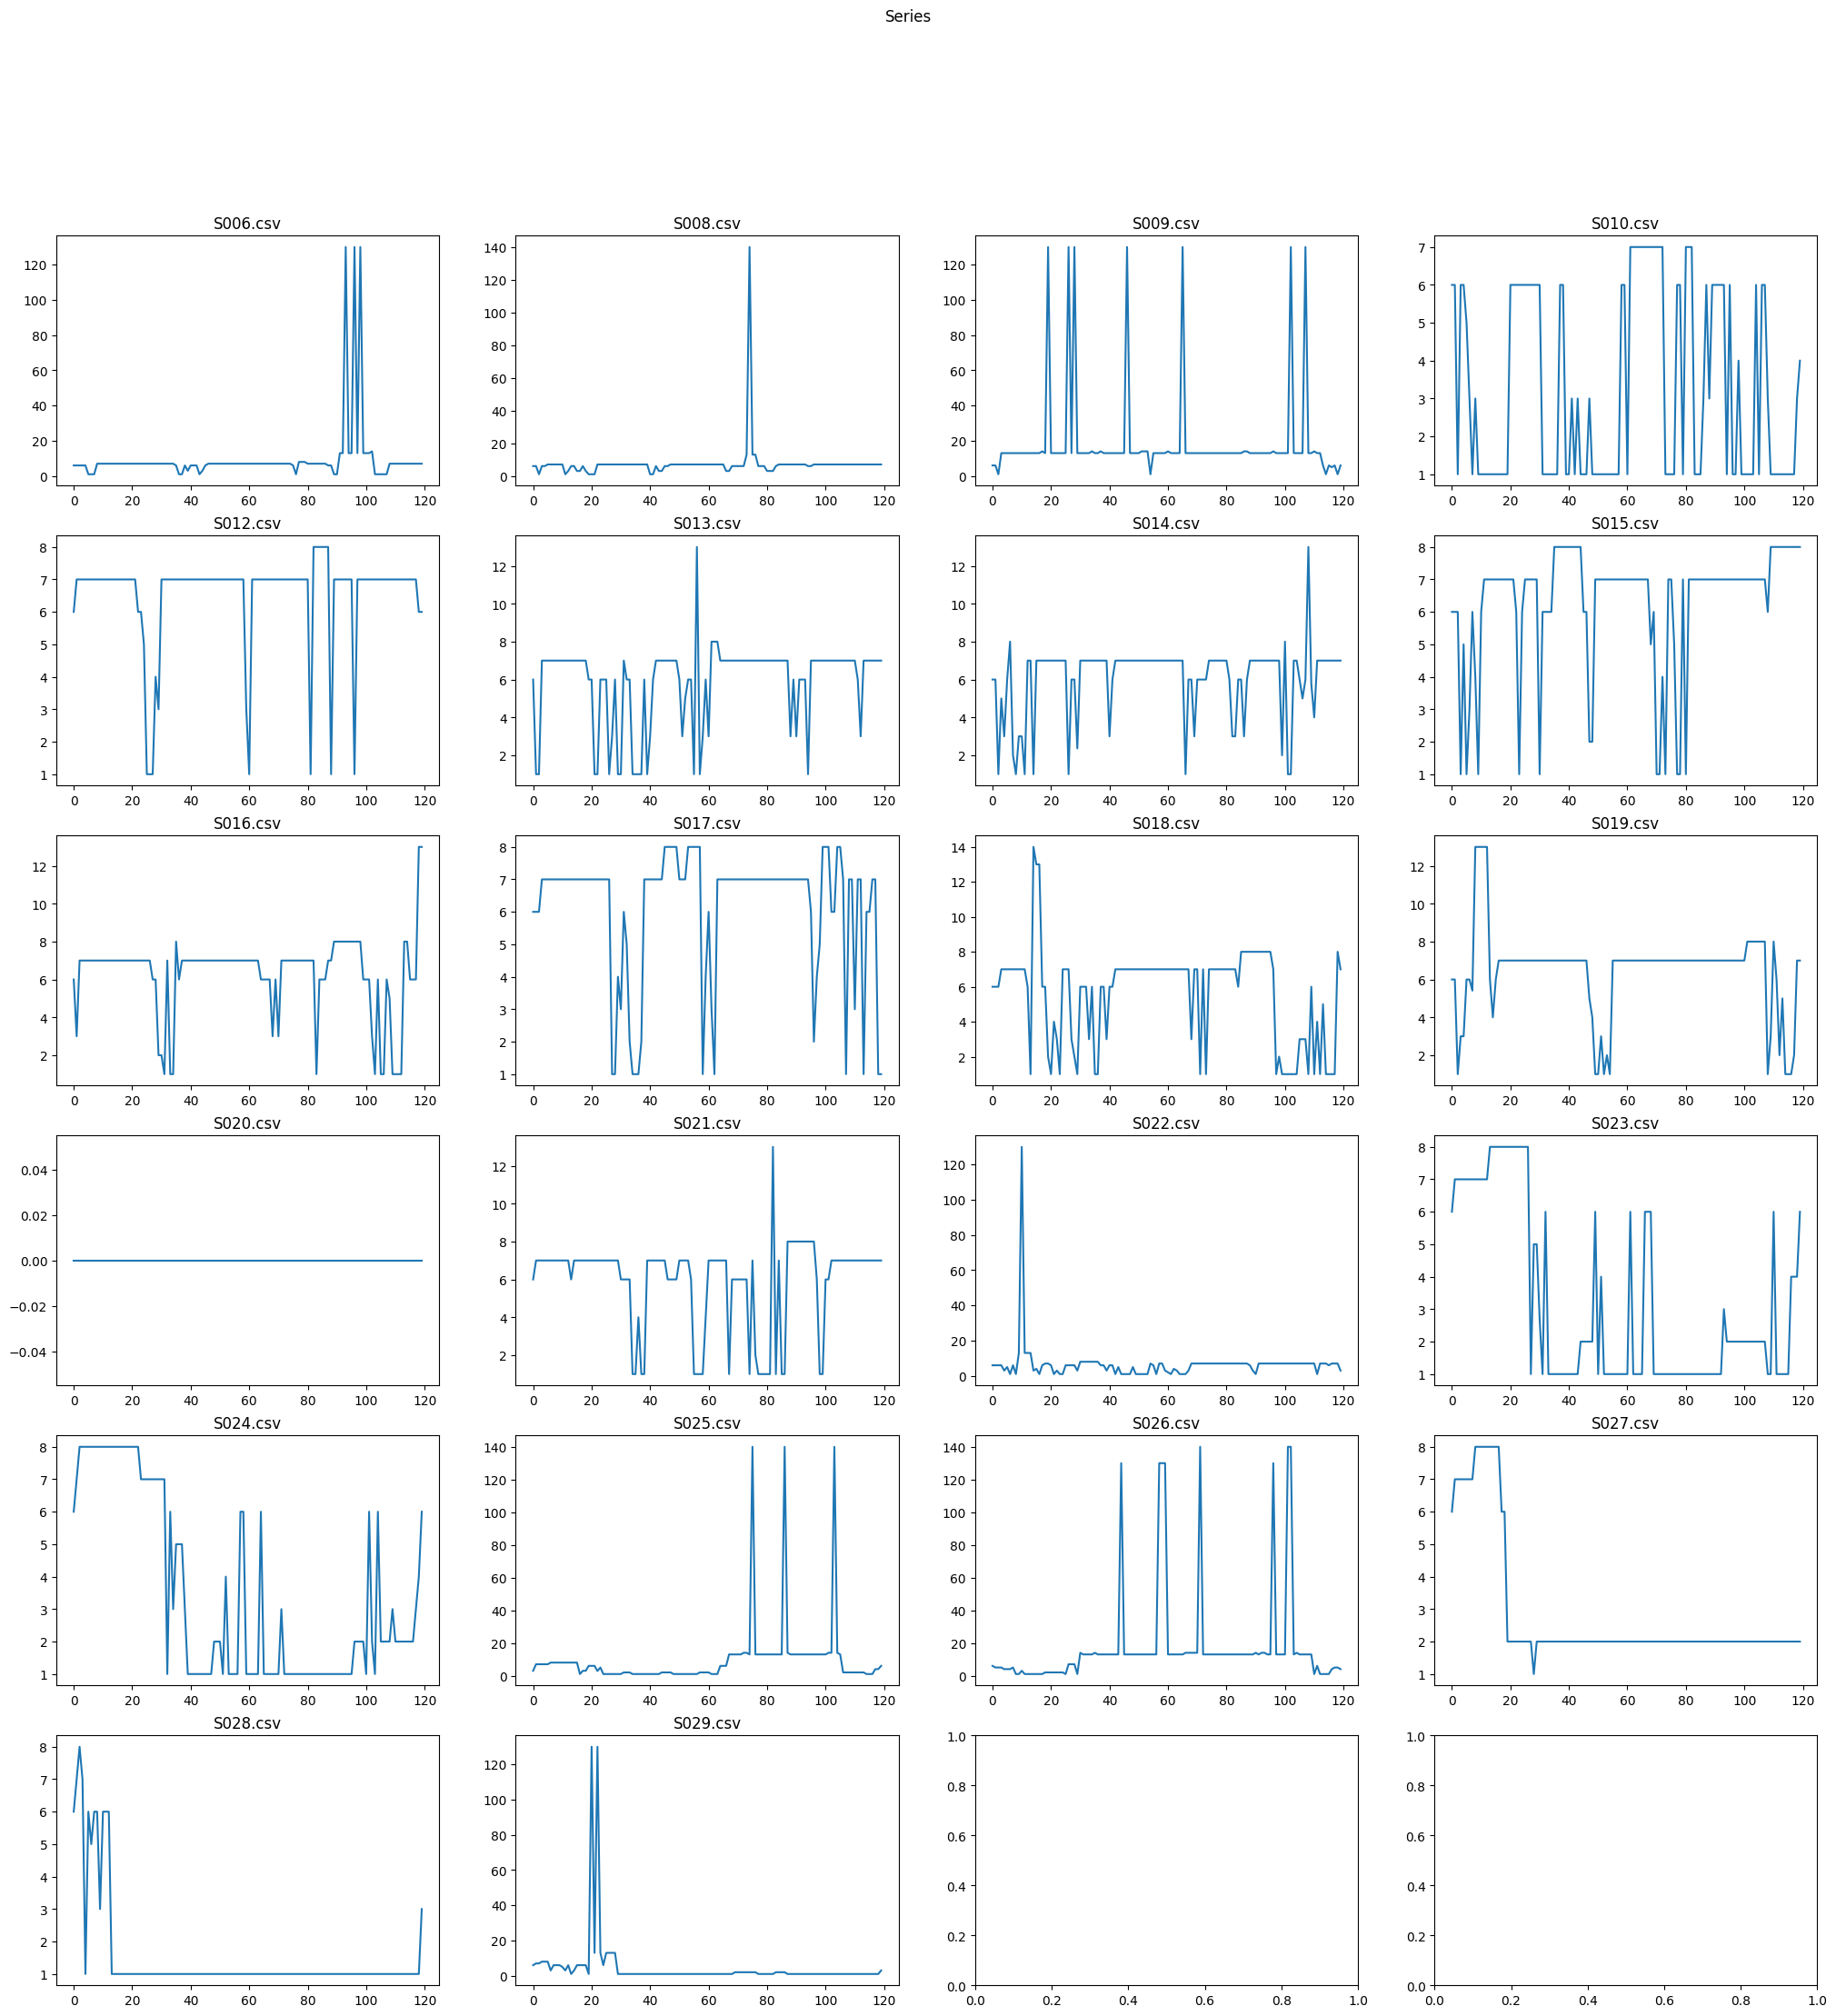

In [8]:
from tslearn.clustering import TimeSeriesKMeans

Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
    
    km = km.fit(df)
    Sum_of_squared_distances.append(km.inertia_)

fig, axs = plt.subplots(6, 4, figsize=(25, 25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        if i * 4 + j >= len(csv_files):  # stop if we exceed the number of CSV files
            break
        # Plot the time series data
        axs[i, j].plot(time_series_data[i * 4 + j])
        # Extract the CSV file name
        file_name = csv_files[i * 4 + j]
        # Set the subplot title with the CSV file name
        axs[i, j].set_title(file_name)
plt.show()


In [10]:
from sklearn.preprocessing import MinMaxScaler
import math

for i in range(len(time_series_data)):
    scaler = MinMaxScaler()
    # Reshape the 1D array to a 2D array with a single feature
    reshaped_data = time_series_data[i].reshape(-1, 1)
    # Fit and transform the data
    scaled_data = scaler.fit_transform(reshaped_data)
    # Reshape back to 1D array
    time_series_data[i] = scaled_data.ravel()

cluster_count = math.ceil(math.sqrt(len(time_series_data))) 
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(time_series_data)

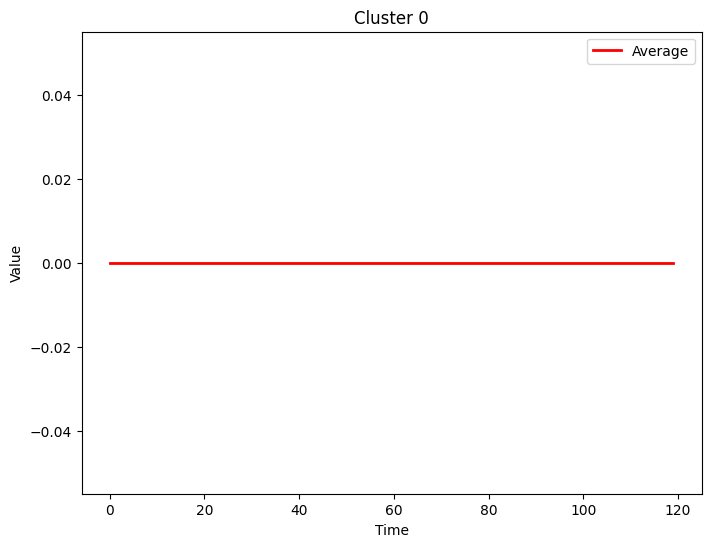

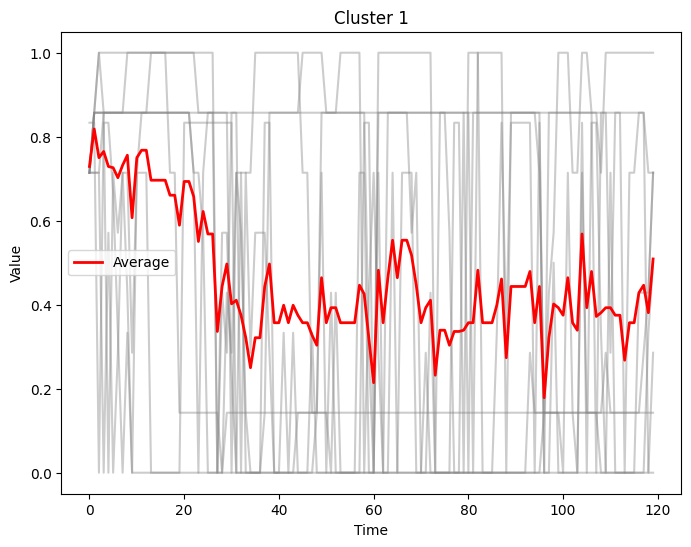

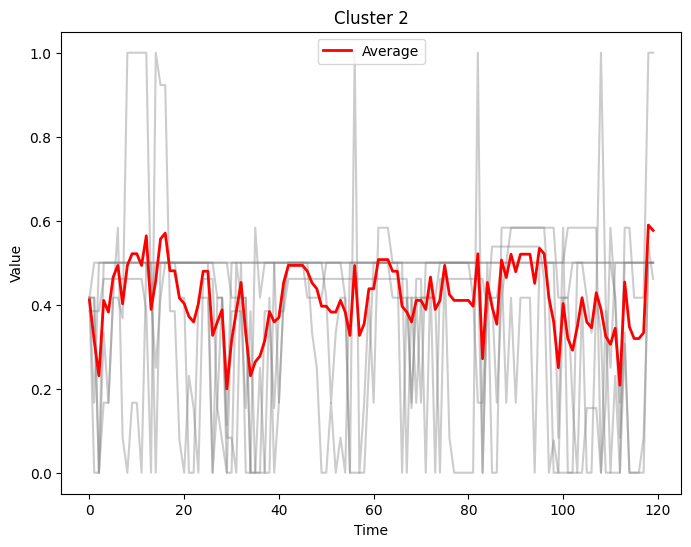

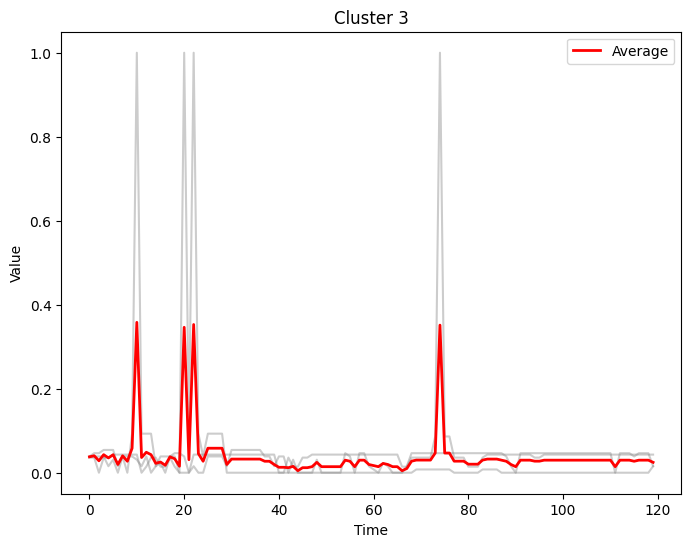

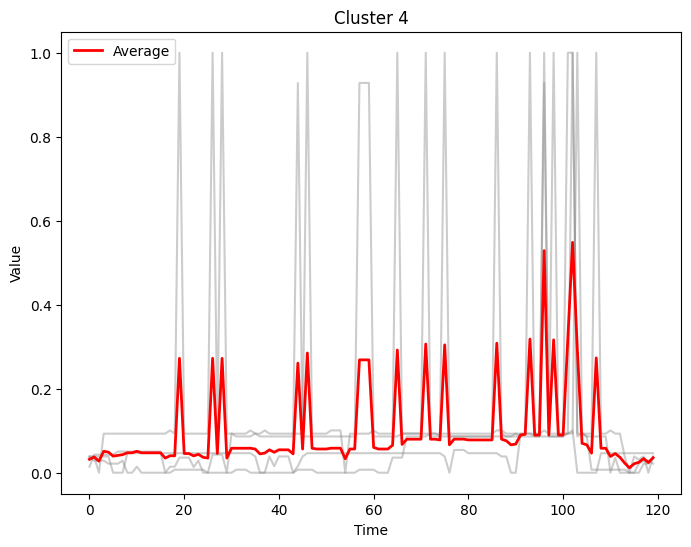

In [13]:
# Algorithms
from minisom import MiniSom


som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(time_series_data))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(time_series_data[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(time_series_data)
som.train(time_series_data, 50000)



# Plot each cluster separately
for label in range(cluster_count):
    plt.figure(figsize=(8, 6))
    plt.title(f'Cluster {label}')
    cluster_indices = np.where(labels == label)[0]
    cluster_data = [time_series_data[i] for i in cluster_indices]
    for data in cluster_data:
        plt.plot(data, color='gray', alpha=0.4)
    average_cluster_data = np.mean(np.vstack(cluster_data), axis=0)
    plt.plot(average_cluster_data, color='red', linewidth=2, label='Average')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()

In [15]:
# Create a DataFrame with CSV file names and cluster labels
cluster_info = pd.DataFrame({'CSV_File': csv_files, 'Cluster_Label': labels})

# Print the DataFrame
print(cluster_info)

    CSV_File  Cluster_Label
0   S006.csv              4
1   S008.csv              3
2   S009.csv              4
3   S010.csv              1
4   S012.csv              1
5   S013.csv              2
6   S014.csv              2
7   S015.csv              1
8   S016.csv              2
9   S017.csv              1
10  S018.csv              2
11  S019.csv              2
12  S020.csv              0
13  S021.csv              2
14  S022.csv              3
15  S023.csv              1
16  S024.csv              1
17  S025.csv              4
18  S026.csv              4
19  S027.csv              1
20  S028.csv              1
21  S029.csv              3
